# Avaliação de Modelos

## Objetivo
Comparar o desempenho dos modelos treinados (Random Forest e Logistic Regression) nos conjuntos de treino e teste, com foco na classe 0 (clientes adimplentes).

In [54]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import seaborn as sns
import joblib
import matplotlib.pyplot as plt

In [55]:
sns.set_palette("Set2")
sns.set_style("whitegrid")
sns.set_context("talk") 

In [56]:
x_train = pd.read_csv("data/processed/x_train.csv")
x_test  = pd.read_csv("data/processed/x_test.csv")
y_train = pd.read_csv("data/processed/y_train.csv").values.ravel()
y_test  = pd.read_csv("data/processed/y_test.csv").values.ravel()

In [57]:
rf = joblib.load("models/rf.pkl")
lr = joblib.load("models/lr.pkl")

## Definição de Threshold
- Ajuste do threshold para maximizar o F1-Score Macro
- Calculado separadamente para cada modelo e conjunto

In [58]:
def find_best_threshold_macro(model, x, y):
    y_proba = model.predict_proba(x)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 81)
    f1_scores = [f1_score(y, (y_proba >= t).astype(int), average='macro') for t in thresholds]
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], y_proba

## Avaliação por Métricas
- Métricas utilizadas: Precisão, Recall e F1
- Avaliação tanto no conjunto de treino quanto no conjunto de teste
- Relatório das métricas e predições

In [59]:
def evaluate_model(model, x, y, name):
    best_thresh, y_proba = find_best_threshold_macro(model, x, y)
    y_pred = (y_proba >= best_thresh).astype(int)
    
    return {
        "Modelo": name,
        "Precisão": precision_score(y, y_pred, pos_label=0),
        "Recall": recall_score(y, y_pred, pos_label=0),
        "F1": f1_score(y, y_pred, pos_label=0),
        "Predições": y_pred
    }

In [60]:
rf_train_metrics = evaluate_model(rf, x_train, y_train, "Random Forest (Treino)")
rf_test_metrics  = evaluate_model(rf, x_test, y_test, "Random Forest (Teste)")

lr_train_metrics = evaluate_model(lr, x_train, y_train, "Logistic Regression (Treino)")
lr_test_metrics  = evaluate_model(lr, x_test, y_test, "Logistic Regression (Teste)")

In [61]:
results_df = pd.DataFrame([
    rf_train_metrics, rf_test_metrics,
    lr_train_metrics, lr_test_metrics
])

In [62]:
results_df_display = results_df[["Modelo", "Precisão", "Recall", "F1"]].round(2)
print("\n=== Comparação Final - Treino vs Teste ===")
print(results_df_display.to_string(index=False))



=== Comparação Final - Treino vs Teste ===
                      Modelo  Precisão  Recall   F1
      Random Forest (Treino)      0.96    0.93 0.95
       Random Forest (Teste)      0.85    0.89 0.87
Logistic Regression (Treino)      0.87    0.85 0.86
 Logistic Regression (Teste)      0.86    0.87 0.86


## Comparação Final
- Tabela comparativa entre os modelos e conjuntos (treino vs teste)

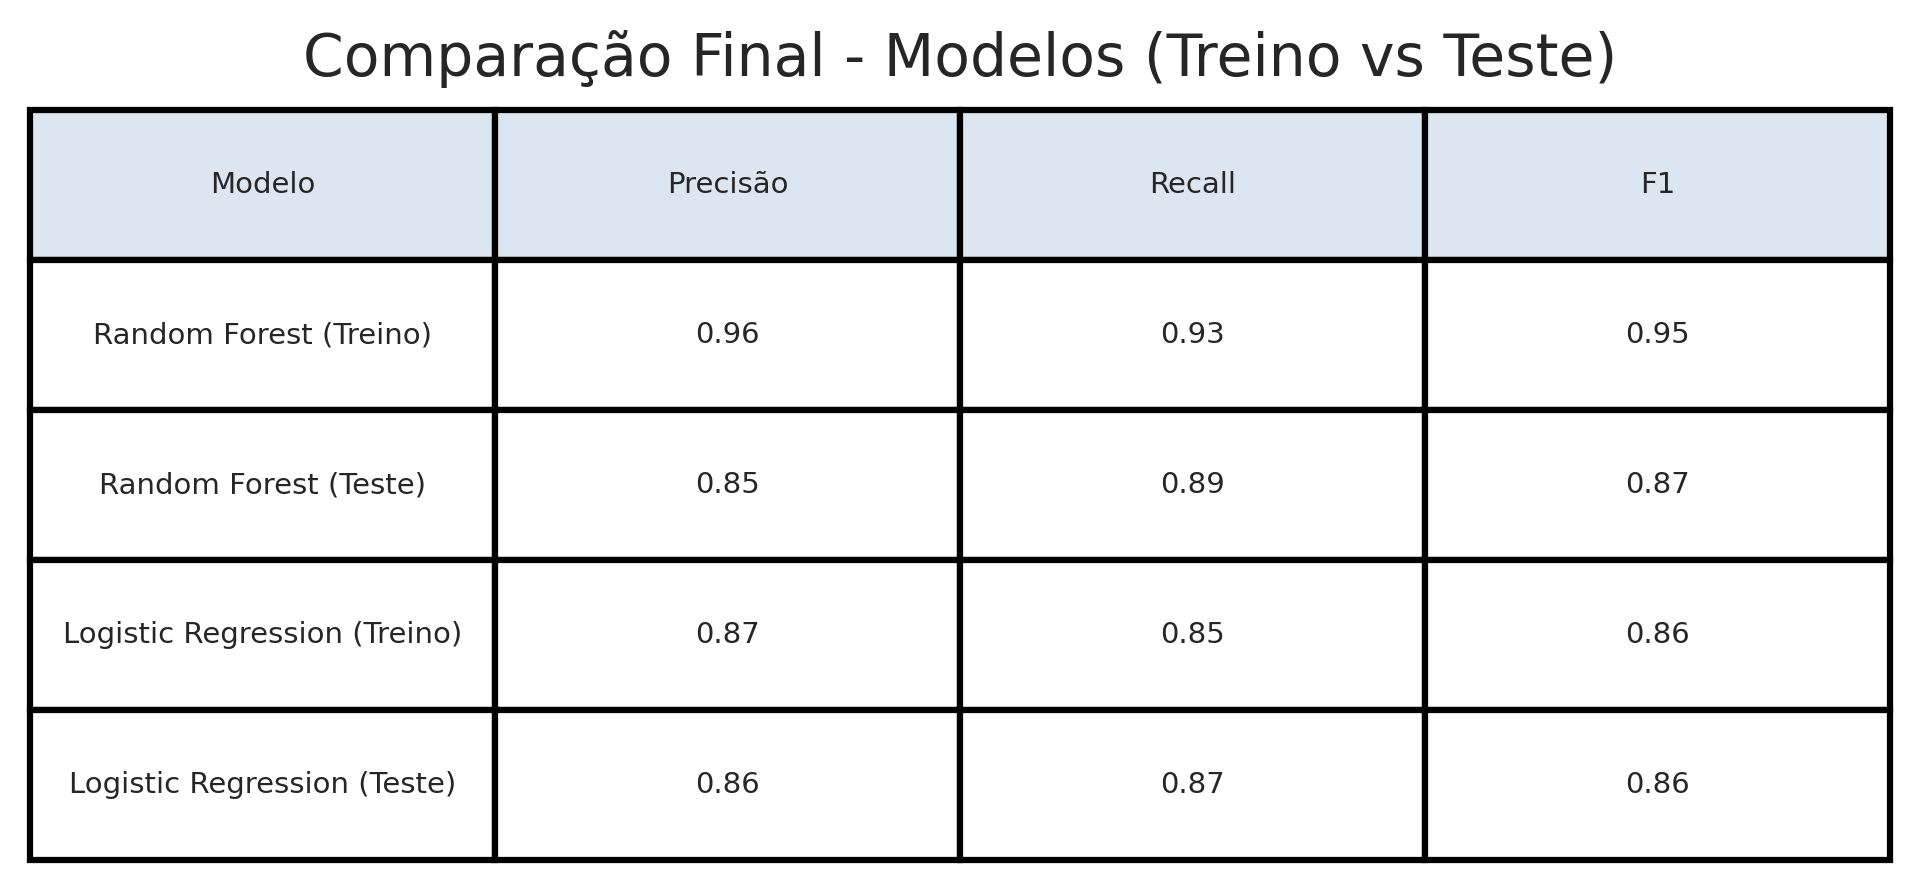

In [63]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=results_df_display.values,
    colLabels=results_df_display.columns,
    cellLoc='center',
    loc='center',
    colColours=['#dce6f1'] * len(results_df_display.columns)  
)

table.auto_set_font_size(False)
table.set_fontsize(7)
table.scale(2, 3)

plt.title("Comparação Final - Modelos (Treino vs Teste)", fontsize=14, pad=15)
plt.show()